In [87]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import pandas as pd

In [88]:
path_to_data = '/Users/janbraunsdorff/Studienarbeit-projekt/data'
path_to_validation_annotation = path_to_data + "/validation.csv"
path_to_training_annotation = path_to_data + "/training.csv"
path_to_validatoin_data = path_to_data + '/boneage-validation-dataset/'
path_to_training_data = path_to_data + '/boneage-training-dataset/'
path = path_to_data + '/pickel/v3'

In [112]:
model = torch.load('model/vit.pht', map_location=torch.device('cpu'))
model.eval()
print('**done**')

**done**


In [113]:
def processImages(img_path, resize_to=500, reduce_to=380, out_to=256):
    img = cv2.imread(img_path)
    size_target = resize_to
    img = cv2.resize(img, (resize_to, resize_to), interpolation=cv2.INTER_LINEAR)

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)


    x = y = (size_target - reduce_to) // 2
    h = w = reduce_to
    img = bgr[y:y + h, x:x + w]

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    kernel = np.ones((2,2),np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    img = cv2.resize(img, (out_to, out_to), interpolation=cv2.INTER_LINEAR)

    
    return img

def img_to_tensor(base_path):
    img = processImages(img_path=base_path)
    arr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    t_img = torch.tensor(arr)
    t_img_normalize = t_img.unsqueeze(0)

    return t_img_normalize

In [114]:
img = img_to_tensor(path_to_training_data + "1377.png")

In [115]:
t_img = img.unsqueeze(0)
t_img.shape

torch.Size([1, 1, 256, 256])

/usr/local/lib/python3.9/site-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


<Figure size 2000x2000 with 0 Axes>

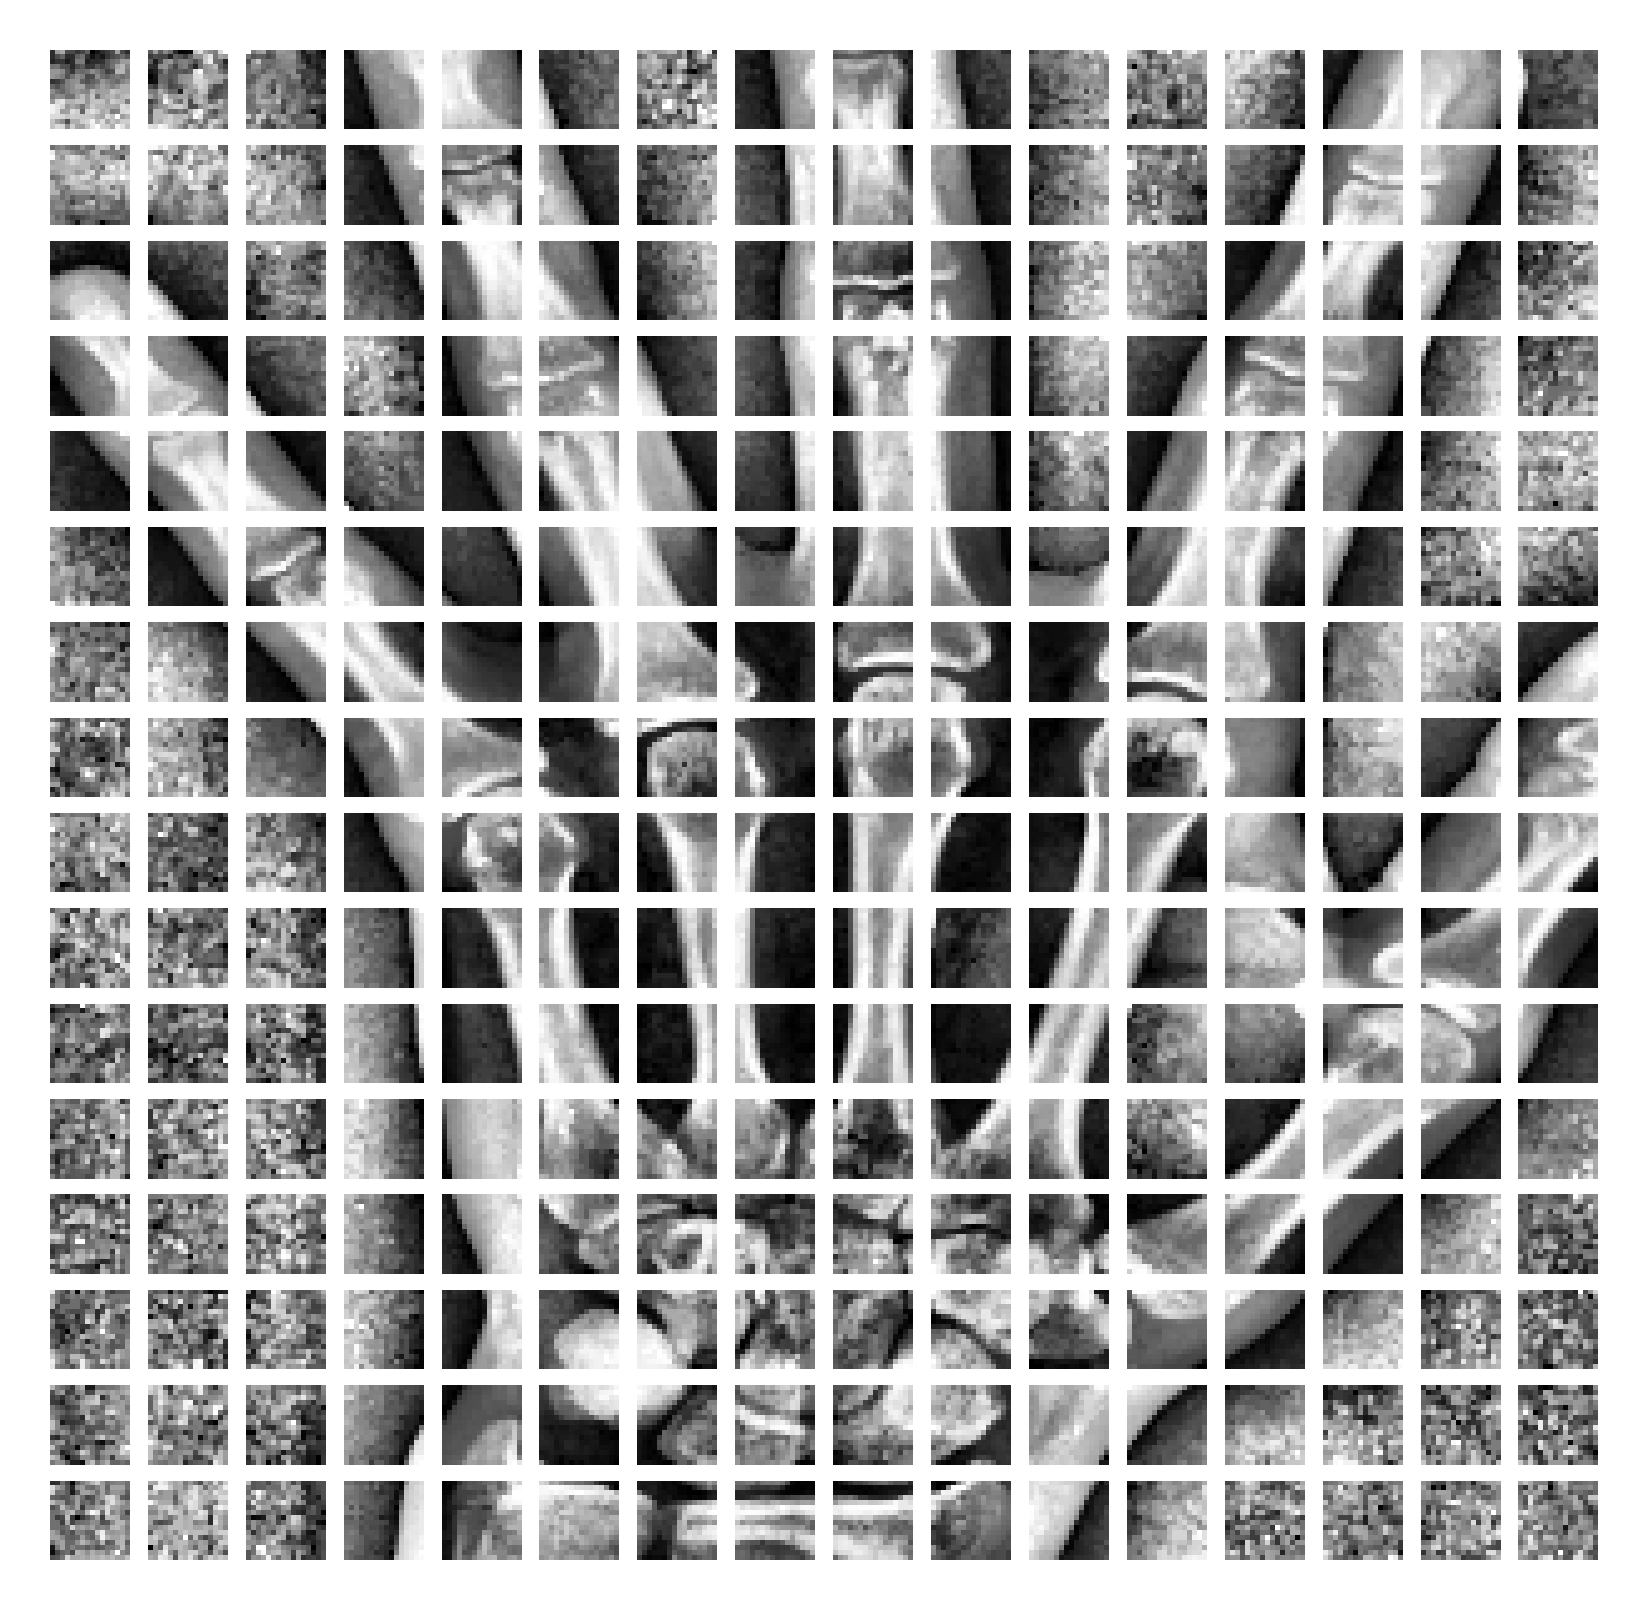

In [116]:
patches = model.patches(t_img)
plt.figure(figsize=(4,4))
n = 16
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_img = patch.reshape(1, 16, 16).permute(1,2,0)
    plt.imshow(patch_img.numpy(), cmap='gray')
    plt.axis('off')

In [117]:
encoding = model.encode_patches(patches.float())

In [118]:
trans_res = encoding
trans_result = []
attention = []
for t in model.transformers:
    x1 = t.norm_1(trans_res)
    attention_output = t.mha(x1,x1,x1)
    attention.append(attention_output[1])
    x2 = attention_output[0] + trans_res
    x3 = t.norm_2(x2)
    x3 = t.mlp(x3)
    trans_res = x3 + x2
    trans_result.append(trans_res)

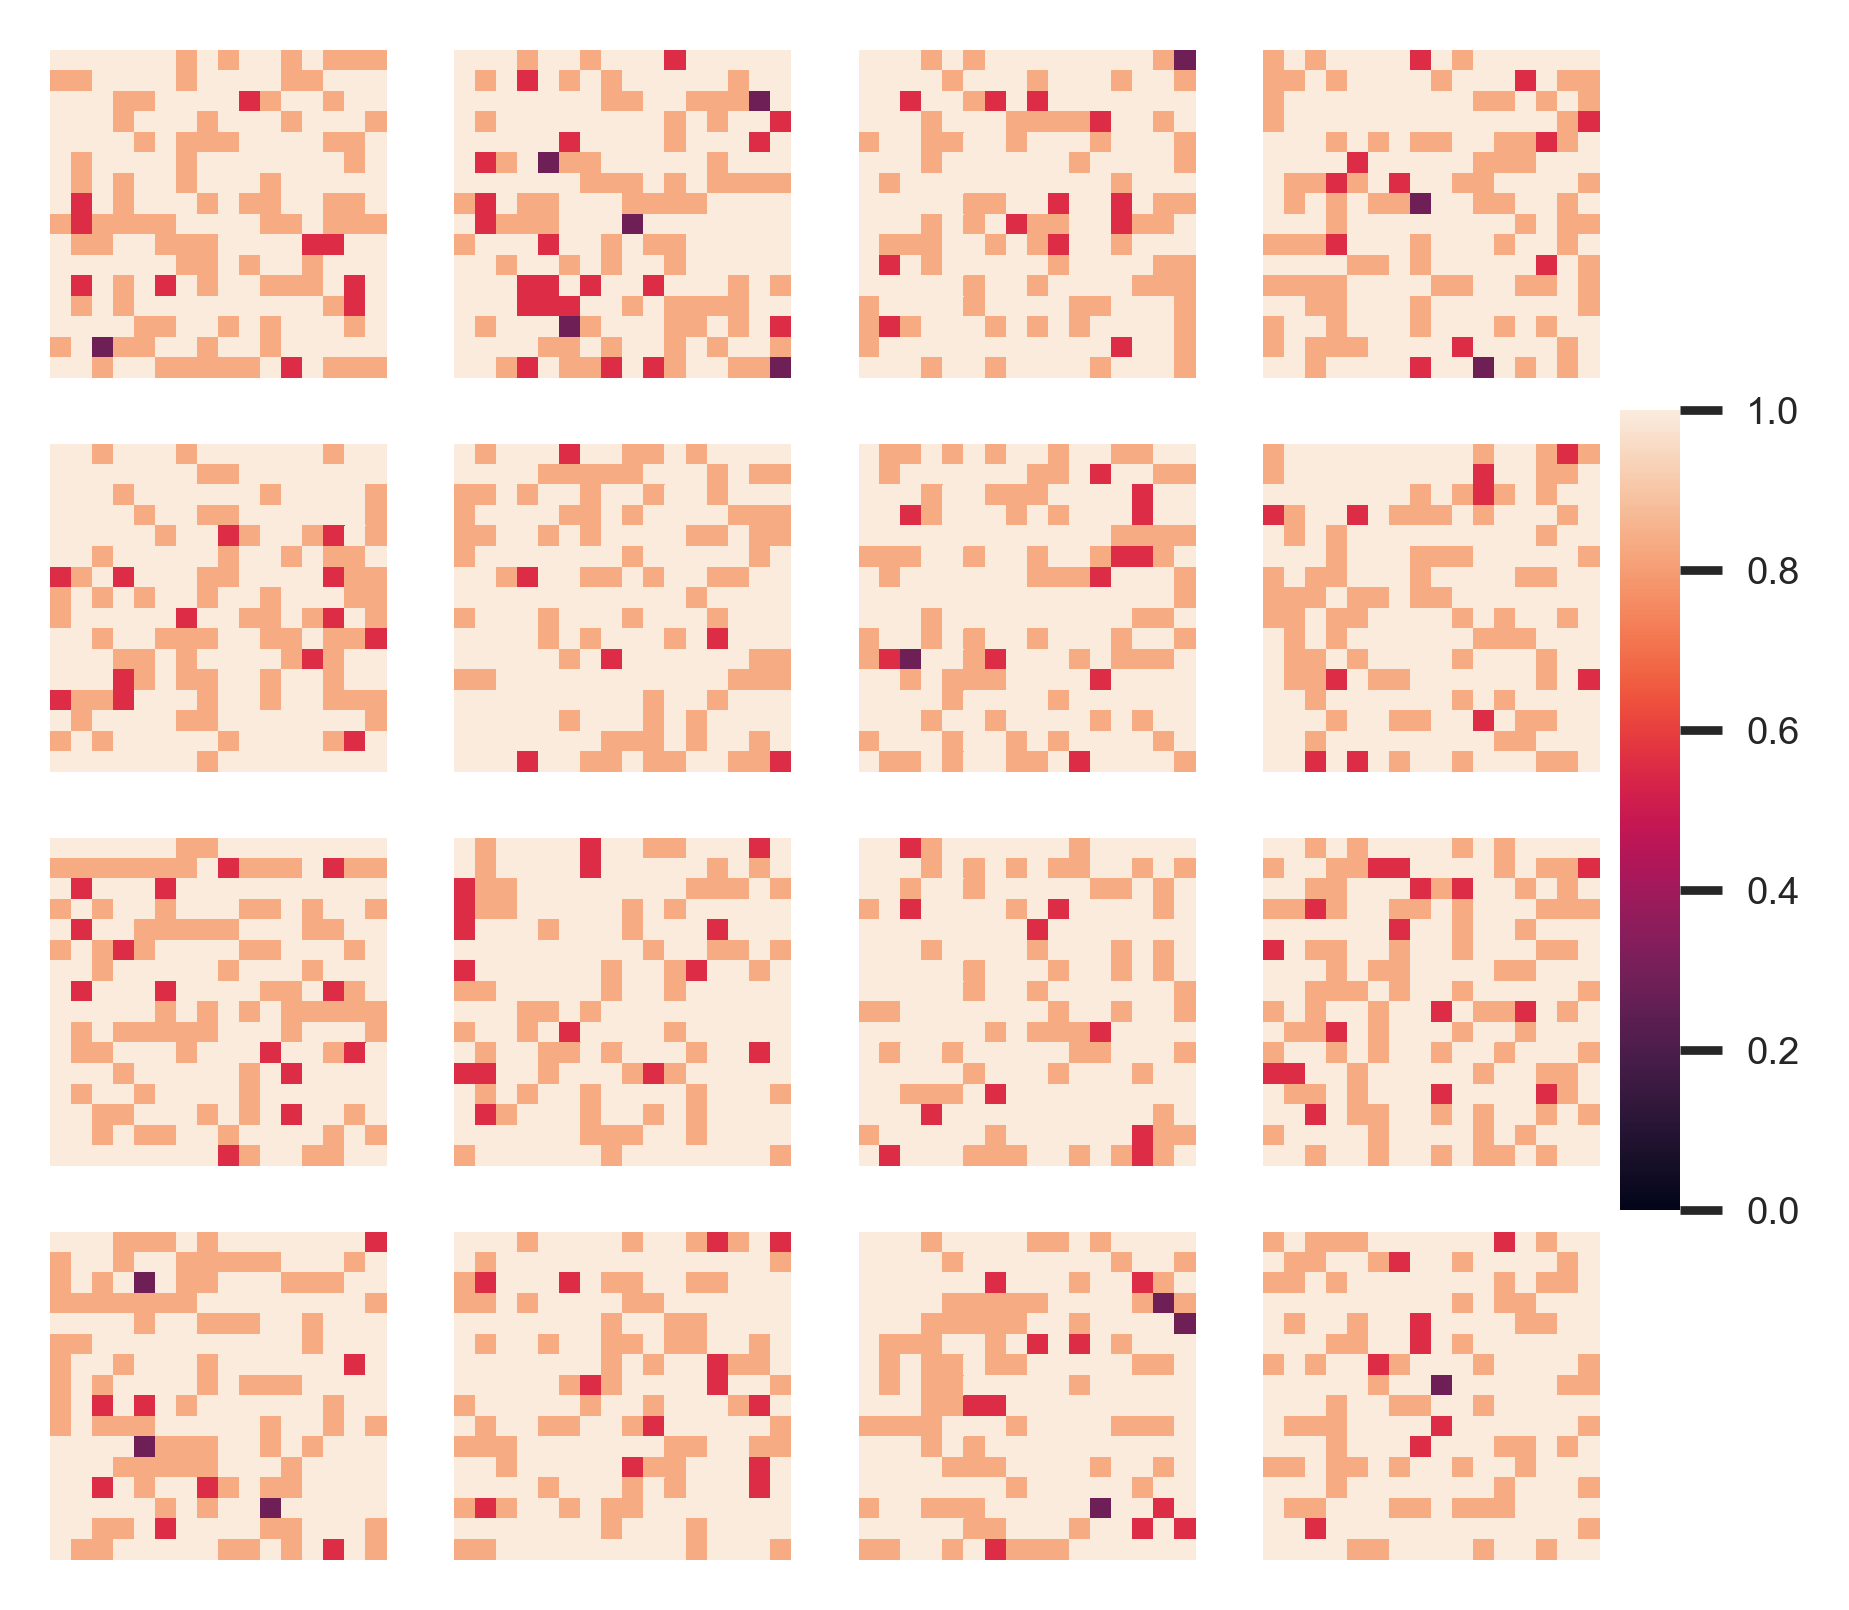

In [119]:
fig, axn = plt.subplots(4, 4, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axn.flat):
    ax = sns.heatmap(
        attention[i].squeeze(1).reshape(16, 16).detach().numpy(), 
        ax=ax,
        cbar=i == 0,
        vmin=0, vmax=1,
        cbar_ax=None if i else cbar_ax,
        annot=False,
        xticklabels=False, 
        yticklabels=False
    )
    ax.tick_params(left=False, bottom=False)